# Overlaying images

Readme:
1. Create a new folder, where the new images and labels should go to. Create "images" and "labels" folder also.
2. Set the correct folders in the following cell
3. Run all cells until "For testing". Can take up to 20 minutes.
4. Run "For testing"-cell to check if the bounding boxes are correctly done

In [1]:
INPUT_FOLDER = "/home/jetracer/Documents/3d_mai/data/train_threads_b/"
IMAGES_FOLDER = "images/"
LABELS_FOLDER = "labels/"

OUTPUT_PATH = "/home/jetracer/Documents/3d_mai/data/train_threads_b/overlaying/"

In [2]:
def relative_to_absolute_relative_center(bbox, image_width, image_height):
    """
    Convert bounding box coordinates with relative center to absolute coordinates.

    Parameters:
    - bbox: Tuple (x_middle_rel, y_middle_rel, width_rel, height_rel) representing relative coordinates.
    - image_width: Width of the image.
    - image_height: Height of the image.

    Returns:
    Tuple (x_min, y_min, x_max, y_max) representing absolute coordinates.
    """
    x_middle_rel, y_middle_rel, width_rel, height_rel = bbox
    x_middle_rel = float(x_middle_rel)
    y_middle_rel = float(y_middle_rel)
    width_rel = float(width_rel)
    height_rel = float(height_rel)

    x_min = int((x_middle_rel - width_rel / 2) * image_width)
    y_min = int((y_middle_rel - height_rel / 2) * image_height)
    x_max = int((x_middle_rel + width_rel / 2) * image_width)
    y_max = int((y_middle_rel + height_rel / 2) * image_height)

    return x_min, y_min, x_max, y_max

# Example usage:
relative_bbox_center = (0.5, 0.5, 0.4, 0.3)  # Example relative bounding box with center coordinates
image_width = 1920  # Example image width
image_height = 1080  # Example image height

absolute_bbox = relative_to_absolute_relative_center(relative_bbox_center, image_width, image_height)
print("Absolute Bounding Box:", absolute_bbox)



Absolute Bounding Box: (576, 378, 1344, 702)


In [3]:
"""Replace (255,255,255) with transparent of Pillow images.
"""
def make_white_transparent(img):
    # Convert the image to RGBA (if not already in that mode)
    img = img.convert("RGBA")

    # Get the image data as a list of tuples
    data = list(img.getdata())

    # Create a new list with transparency
    new_data = [(r, g, b, 0) if (r, g, b) == (255, 255, 255) else (r, g, b, a) for r, g, b, a in data]

    # Update the image data
    img.putdata(new_data)

    return img


### Overlay multiple images by turning (255, 255, 255) to transparent

In [4]:
import os
def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files

files = get_files_in_subdirectories(INPUT_FOLDER + IMAGES_FOLDER, file_extension=".png")
print(files[:5])
len(files)

['/home/jetracer/Documents/3d_mai/data/train_threads_b/images/din125_m4_x-1_y-0_z-4_z-z2oom.png', '/home/jetracer/Documents/3d_mai/data/train_threads_b/images/m4_20mm_x-1_y-1_z-3_z-z3oom.png', '/home/jetracer/Documents/3d_mai/data/train_threads_b/images/din125_m4_x-0_y-1_z-4_z-z3oom.png', '/home/jetracer/Documents/3d_mai/data/train_threads_b/images/asy_m4_nut_screw_10mm_x-4_y-4_z-4_z-z1oom.png', '/home/jetracer/Documents/3d_mai/data/train_threads_b/images/asy_m4_nut_screw_10mm_x-2_y-1_z-0_z-z3oom.png']


1875

### Create batches of random images 

In [5]:
from PIL import Image
def overlay_and_save_images(image_names, input_root_folder, output_root_folder, output_name, WIDTH=1920, HEIGHT=1080):
    IMAGES_FOLDER = "images/"
    LABELS_FOLDER = "labels/"

    labels_lines_history = []

    # Create white background as starting point
    new_image = Image.new("RGBA", (WIDTH, HEIGHT), (0,0,0,0))

    for idx, image_path in enumerate(image_names):
        with open(input_root_folder + LABELS_FOLDER + image_path + '.txt', 'r') as file:
            for line in file:
                # Do something with the line (e.g., print it)
                bbox_line = line.strip()
                labels_lines_history.append(bbox_line)

        # open image
        image = Image.open(input_root_folder + IMAGES_FOLDER + image_path + ".png")

        # Replace (255,255,255) to transparent
        image_transparent = make_white_transparent(image)

        # Overlay images
        new_image.paste(image_transparent, (0,0), image_transparent)


    # Turn transparent back to white
    # Paste the RGBA image onto the RGB image, using the alpha channel to blend
    # Create a new RGB image with a white background
    rgb_img = Image.new("RGB", new_image.size, "white")
    rgb_img.paste(new_image, mask=new_image.split()[3])

    OUTPUT_FILE_NAME = output_name
    # Save image
    image_path_save = output_root_folder + IMAGES_FOLDER + OUTPUT_FILE_NAME + ".png"
    rgb_img.save(image_path_save)
    #print("saving to:", image_path_save)

    # Save labels file
    # Create new label file and fill with bbox_history 
    label_output_path = output_root_folder + LABELS_FOLDER + OUTPUT_FILE_NAME + ".txt"
    with open(label_output_path, 'w') as file:
        for bbox_line in labels_lines_history:
            file.write(bbox_line + "\n")
    #print("saving to:", label_output_path)

In [6]:
image_paths = get_files_in_subdirectories(INPUT_FOLDER + IMAGES_FOLDER, file_extension=".png")
# shuffle for randomness
import random
random.shuffle(image_paths)

BATCH_SIZE = 4
batch_idx = 0
while len(image_paths) > 0:
    # Get BATCH_SIZE number of image_path roots
    popped_items = [image_paths.pop() for _ in range(min(BATCH_SIZE, len(image_paths)))]
    image_roots = [image_path.split("/")[-1].split(".")[0] for image_path in popped_items]

    # Now overlay the image and create the new label file
    overlay_and_save_images(image_roots, INPUT_FOLDER, OUTPUT_PATH, str(batch_idx))

    batch_idx += 1

# asdf

### For testing: Show bounding boxes from label file

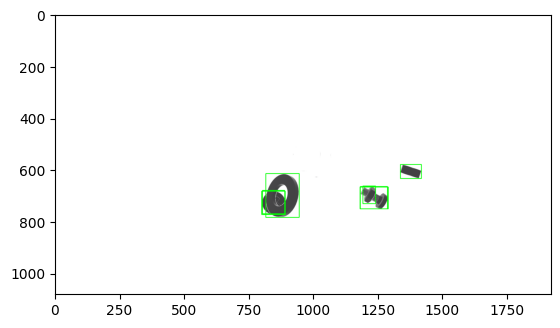

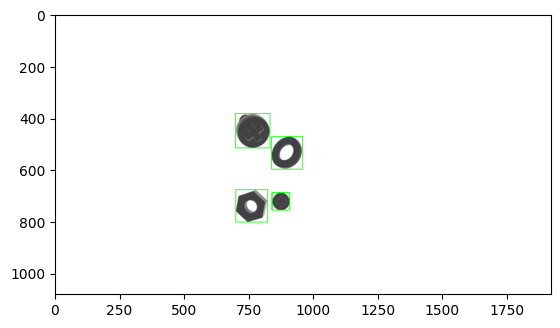

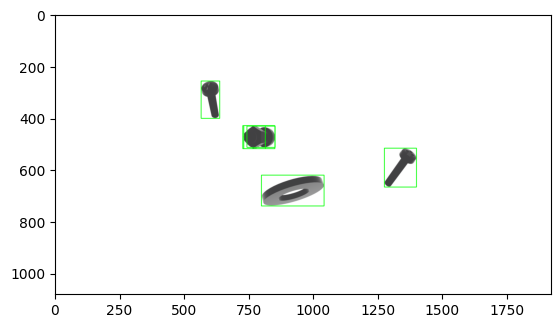

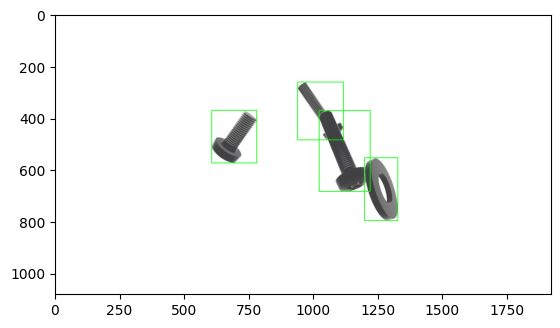

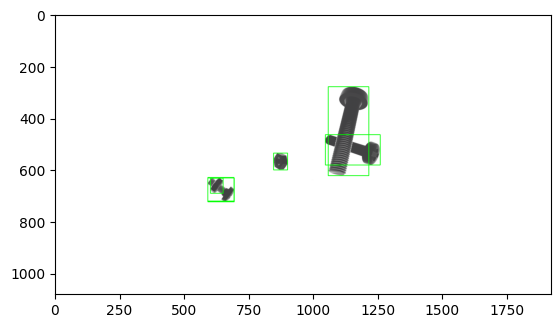

'\n# Save image with bounding boxes (wbb)\nimport cv2\nCOLOR_BBOX = (0,255,0)\nwbb_image_path_save = OUTPUT_PATH + "image_test_wbb.png"\nfor label_line in labels_lines_history:\n    rel_bbox = label_line.strip().split(\' \')[:1]\n    abs_bbox = relative_bbox_center(rel_bbox, WIDTH, HEIGHT)\n    cv2.rectangle(new_image, (abs_bbox[0], abs_bbox[1]), (abs_bbox[2], abs_bbox[3]), COLOR_BBOX, thickness=2)    \ncv2.imwrite(wbb_image_path_save, new_image)\nprint("saving to:", wbb_image_path_save)\n'

In [57]:
# Load the two label files, to get the regions of interest that we want to copy

OVERLAYED_IMAGE_PATH = "/home/jetracer/Documents/3d_mai/data/train_threads_b/overlaying/images/0.png"
OVERLAYED_LABEL_PATH = "/home/jetracer/Documents/3d_mai/data/train_threads_b/overlaying/labels/0.txt"
image_paths = []
label_paths = []
for i in range(5):
    image_paths.append(OVERLAYED_IMAGE_PATH.replace("0", str(i)))
    label_paths.append(OVERLAYED_LABEL_PATH.replace("0", str(i)))

WIDTH = 1920
HEIGHT = 1080

import cv2
import matplotlib.pyplot as plt
COLOR_BBOX = (0,255,0)

labels_lines_history = []
for idx, image_path in enumerate(image_paths):
    # Read img
    img = cv2.imread(image_path)

    # Draw bounding boxes from labels file
    label_path = label_paths[idx]
    with open(label_path, 'r') as file:
        for line in file:
            # Do something with the line (e.g., print it)
            rel_bbox = line.strip().split(' ')[1:]
            abs_bbox = relative_to_absolute_relative_center(rel_bbox, WIDTH, HEIGHT)
            cv2.rectangle(img, (abs_bbox[0], abs_bbox[1]), (abs_bbox[2], abs_bbox[3]), COLOR_BBOX, thickness=2)  
          
    # Display image with bounding boxes
    plt.imshow(img)
    plt.show()


"""
# Save image with bounding boxes (wbb)
import cv2
COLOR_BBOX = (0,255,0)
wbb_image_path_save = OUTPUT_PATH + "image_test_wbb.png"
for label_line in labels_lines_history:
    rel_bbox = label_line.strip().split(' ')[:1]
    abs_bbox = relative_bbox_center(rel_bbox, WIDTH, HEIGHT)
    cv2.rectangle(new_image, (abs_bbox[0], abs_bbox[1]), (abs_bbox[2], abs_bbox[3]), COLOR_BBOX, thickness=2)    
cv2.imwrite(wbb_image_path_save, new_image)
print("saving to:", wbb_image_path_save)
"""

### Deprecated: 'Overlaying' images by copying rectangle region of interest of objects

Problem: also copies the white background of the square.

In [ ]:
def udpate_maximum_region_of_interest(bbox, max_roi):
    """Update what part of an image includes an object, by combining the bounding boxes.
    Note: To get the maximum bounding box, we have to find the minimum x1 and y1 and the maximum x2 and y2.

    Parameters:
    - bbox: Tuple (x1, y1, x2, y2) representing absolute coordinates.
    - max_roi: List [x1, y1, x2, y2] representing absolute coordinates.

    Returns:
    Tuple (x_min, y_min, x_max, y_max) representing absolute coordinates of the updated region of interest.
    """
    max_roi[0] = min(bbox[0], max_roi[0]) # x1
    max_roi[1] = min(bbox[1], max_roi[1]) # y1
    max_roi[2] = max(bbox[2], max_roi[2]) # x2
    max_roi[3] = max(bbox[3], max_roi[3]) # y2
    return max_roi

In [97]:
# Load the two label files, to get the regions of interest that we want to copy

image_paths = [IMAGE_1, IMAGE_2]

WIDTH = 1920
HEIGHT = 1080
COLOR_BBOX = (0, 255, 0)

labels_lines_history = []
bbox_history = []

new_image = cv2.imread(INPUT_FOLDER + IMAGES_FOLDER + image_paths[0] + ".png")

import cv2
for idx, image_path in enumerate(image_paths):
    with open(INPUT_FOLDER + LABELS_FOLDER + image_path + '.txt', 'r') as file:
        # open image
        image = cv2.imread(INPUT_FOLDER + IMAGES_FOLDER + image_path + ".png")

        # Find the region of interest by combining the bounding boxes.
        # Initializing with the "worst" values, to be able to update them when seeing new bounding box labels.
        x1_min = image.shape[1] # 1920
        y1_min = image.shape[0] # 1080
        x2_max = 0
        y2_max = 0
        max_region_of_interest = [x1_min, y1_min, 0, 0]

        # Read and process each line
        for line in file:
            # Do something with the line (e.g., print it)
            bbox_line = line.strip()
            labels_lines_history.append(bbox_line)
            bbox = bbox_line.split(" ")
            relative_bbox = (float(bbox[1]), float(bbox[2]), float(bbox[3]), float(bbox[4]))

            absolute_bbox = relative_to_absolute_relative_center(relative_bbox, image.shape[1], image.shape[0])
            bbox_history.append(absolute_bbox)

            max_region_of_interest = udpate_maximum_region_of_interest(absolute_bbox, max_region_of_interest)

        # Copy region of interest to new image
        new_image[
            max_region_of_interest[1]:max_region_of_interest[3], # First y 
            max_region_of_interest[0]:max_region_of_interest[2]  # Then x, since image.shape is (height, width, c_channels)
        ] = image[
            max_region_of_interest[1]:max_region_of_interest[3],
            max_region_of_interest[0]:max_region_of_interest[2]
        ]

# Save image
image_path_save = OUTPUT_PATH + "image_test.png"
cv2.imwrite(image_path_save, new_image)
print("saving to:", image_path_save)

# Save image with bounding boxes (wbb)
wbb_image_path_save = OUTPUT_PATH + "image_test_wbb.png"
for bbox in bbox_history:
    cv2.rectangle(new_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), COLOR_BBOX, thickness=2)    
cv2.imwrite(wbb_image_path_save, new_image)
print("saving to:", wbb_image_path_save)

# Save labels file
# Create new label file and fill with bbox_history 
label_output_path = OUTPUT_PATH + "test.txt"
with open(label_output_path, 'w') as file:
    for bbox_line in labels_lines_history:
        file.write(bbox_line + "\n")
print("saving to:", label_output_path)


        

saving to: /home/jetracer/Documents/3d_mai/data/train_threads_b/overlaying/image_test.png
saving to: /home/jetracer/Documents/3d_mai/data/train_threads_b/overlaying/image_test_wbb.png
saving to: /home/jetracer/Documents/3d_mai/data/train_threads_b/overlaying/test.txt
